In [1]:
#Pretraining on unlabeled data
#Evaluating generative text models

In [2]:
import torch

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [4]:
#Previous chapters imported
# CHAPTER 2
import tiktoken
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

class GPTDatasetV1(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        #Tokenize the entire text
        token_ids = tokenizer.encode(txt, allowed_special={"<|endoftext|>"})

        #Use a sliding window to chunk the book into overlapping sequences of max_length
        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i:i + max_length]
            target_chunk = token_ids[i+1: i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids) 

    def __getitem__(self,idx):
        return self.input_ids[idx], self.target_ids[idx]

def create_dataloader_v1(txt, batch_size=4, max_length=256, stride=128, shuffle=True, drop_last=True, num_workers=0):
    #Initialize the tokenizer
    tokenizer = tiktoken.get_encoding("gpt2")
    
    #Create dataset
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)
    
    #Create dataloader
    dataloader = DataLoader(
    dataset, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last, num_workers=num_workers)
    
    return dataloader

#  CHAPTER 3

class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert( d_out % num_heads == 0 ), \
            "d_out must be divisible by num_heads"
        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length),
                       diagonal=1)
        )

    def forward(self, x):
        b, num_tokens, d_in = x.shape
        #Shape: (b, num_tokens, d_out)
        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)
        #We implicitly split the matrix by adding a num_heads dimension
        #Unroll last dim: (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)
        # Transpose: (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)
        #Compute scaled dot product attention (aka self attention) with a causal mask
        attn_scores = queries @ keys.transpose(2, 3) #Dot product for each head
        #Original mask truncated to the number of tokens and converted to boolean
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]
        #Use the mask to fill attention scores
        attn_scores.masked_fill_(mask_bool, -torch.inf)
        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)
        #Shape: (b, num_tokens, num_heads, head_dim)
        context_vec = (attn_weights @ values).transpose(1, 2)
        #Combine heads, where self.d_out = elf.num_heads * self.head_dim
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec) #Optional Projection
        return context_vec

# CHAPTER 4

class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x-mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
                torch.sqrt(torch.tensor(2.0 / torch.pi)) *
                (x + 0.044715 * torch.pow(x, 3))
        ))

class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
        )

    def forward(self, x):
        return self.layers(x)

class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in = cfg["emb_dim"],
            d_out = cfg["emb_dim"],
            context_length = cfg["context_length"],
            num_heads = cfg["n_heads"],
            dropout = cfg["drop_rate"],
            qkv_bias = cfg["qkv_bias"])
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):
        #Shortcut connection for attention block
        shortcut = x
        x = self.norm1(x)
        x = self.att(x) #Shape [batch_size, num_tokens, emb_size]
        x = self.drop_shortcut(x)
        x = x + shortcut #Add the original input back

        #Shortcut connection for feed forward block
        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut #Add the original input back
        return x

class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])

        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

def generate_text_simple(model, idx, max_new_tokens, context_size):
     # Automatically move the input tensor to the model's device (e.g., "cuda")
    device = next(model.parameters()).device
    idx = idx.to(device)
                 
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]

        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]

        probas = torch.softmax(logits, dim=-1)

        idx_next = torch.argmax(probas, dim=-1, keepdim=True)

        idx = torch.cat((idx, idx_next), dim=1)
    return idx

In [5]:
#Using GPT to generate text

from importlib.metadata import version

pkgs = {"matplotlib",
        "numpy",
        "tiktoken",
        "torch",
        "tensorflow" #For OpenAI's Pretrained weights
       }
for p in pkgs:
    print(f"{p} version: {version(p)}")

numpy version: 1.26.4
tensorflow version: 2.16.1
matplotlib version: 3.8.4
torch version: 2.5.1+cu121
tiktoken version: 0.11.0


In [6]:
GPT_CONFIG_124M = {
    "vocab_size": 50257, #Vocabulary size
    "context_length": 256, #Context length
    "emb_dim": 768, #Embedding Dimension
    "n_heads": 12, #Number of attention heads
    "n_layers": 12, #Number of layers
    "drop_rate": 0.1, #Dropout rate
    "qkv_bias": False #Query-Key-Value bias
}

In [7]:
import torch

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval() #Disabling dropout so no random dropping during inference

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

In [8]:
device = "cuda"

In [9]:
model.to(device)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

In [10]:
import torch

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval(); #Disabling dropout so no random dropping during inference

In [11]:
import tiktoken 

def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special = {"<|endoftext|>"})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) #Add bacth dimension
    return encoded_tensor

In [12]:
start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = text_to_token_ids(start_context, tokenizer)
token_ids

tensor([[6109, 3626, 6100,  345]])

In [13]:
def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # remove batch dimension
    return tokenizer.decode(flat.tolist())

token_ids_to_text(token_ids, tokenizer)

'Every effort moves you'

In [14]:
token_ids.squeeze(0).shape

torch.Size([4])

In [15]:
token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_length"]
)

In [16]:
token_ids.squeeze(0).shape

torch.Size([14])

In [17]:
token_ids_to_text(token_ids, tokenizer)

'Every effort moves you rentingetic wasnم refres RexMeCHicular stren'

In [18]:
#Calculating the text generation loss: cross-entropy and perplexity

In [19]:
inputs = torch.tensor([[16833, 3626, 6100], #every effort moves
                      [40, 1107, 588]])     #I really like

targets = torch.tensor([[3626, 6100, 345],  #effort moves you
                       [1107, 588, 11311]]) #really like chocolate

In [20]:
with torch.no_grad():
    logits = model(inputs)

In [21]:
logits.shape

torch.Size([2, 3, 50257])

In [22]:
probas = torch.softmax(logits, dim=-1)
probas.shape

torch.Size([2, 3, 50257])

In [23]:
probas

tensor([[[1.8849e-05, 1.5172e-05, 1.1687e-05,  ..., 2.2409e-05,
          6.9776e-06, 1.8776e-05],
         [9.1569e-06, 1.0062e-05, 7.8786e-06,  ..., 2.9090e-05,
          6.0103e-06, 1.3571e-05],
         [2.9877e-05, 8.8507e-06, 1.5741e-05,  ..., 3.5456e-05,
          1.4094e-05, 1.3526e-05]],

        [[1.2561e-05, 2.0538e-05, 1.4332e-05,  ..., 1.0389e-05,
          3.4784e-05, 1.4239e-05],
         [7.2731e-06, 1.7864e-05, 1.0565e-05,  ..., 2.1206e-05,
          1.1390e-05, 1.5559e-05],
         [2.9496e-05, 3.3605e-05, 4.1029e-05,  ..., 6.5249e-06,
          5.8203e-05, 1.3698e-05]]])

In [24]:
probas.sum()

tensor(6.0000)

In [25]:
token_ids = torch.argmax(probas, dim=-1, keepdim=True)
print("Token IDs:\n", token_ids)

Token IDs:
 tensor([[[16657],
         [  339],
         [42826]],

        [[49906],
         [29669],
         [41751]]])


In [26]:
print(f"Targets batch 1: {token_ids_to_text(targets[0], tokenizer)}")
print(f"Outputs batch 1: {token_ids_to_text(token_ids[0].flatten(), tokenizer)}")

Targets batch 1:  effort moves you
Outputs batch 1:  Armed heNetflix


In [27]:
text_idx = 0
target_probas_1 = probas[text_idx, [0,1,2], targets[text_idx]]
print("Text 1:", target_probas_1)

Text 1: tensor([7.4540e-05, 3.1061e-05, 1.1563e-05])


In [28]:
targets[text_idx]

tensor([3626, 6100,  345])

In [29]:
text_idx = 1
target_probas_2 = probas[text_idx, [0,1,2], targets[text_idx]]
print("Text 2:", target_probas_2)

Text 2: tensor([1.0337e-05, 5.6776e-05, 4.7559e-06])


In [30]:
targets[text_idx]

tensor([ 1107,   588, 11311])

In [31]:
#Compute logarithm of all token probabilities
log_probas = torch.log(torch.cat((target_probas_1, target_probas_2)))
print(log_probas)

tensor([ -9.5042, -10.3796, -11.3677, -11.4798,  -9.7764, -12.2561])


In [32]:
torch.mean(log_probas)

tensor(-10.7940)

In [33]:
-1*torch.mean(log_probas) #Cross-Entropy loss , our aim is to brin it as close to 0 as we can during the training phase

tensor(10.7940)

In [34]:
logits.shape

torch.Size([2, 3, 50257])

In [35]:
logits_flat = logits.flatten(0, 1)
logits_flat.shape

torch.Size([6, 50257])

In [36]:
targets.shape

torch.Size([2, 3])

In [37]:
targets_flat = targets.flatten()
targets_flat.shape

torch.Size([6])

In [38]:
torch.nn.functional.cross_entropy(logits_flat, targets_flat)

tensor(10.7940)

In [39]:
#Calculating the training and validation set losses

In [40]:
import os 
import urllib.request

file_path = "the-verdict-txt"
url = "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/refs/heads/main/ch02/01_main-chapter-code/the-verdict.txt"

if not os.path.exists(file_path):
    with urllib.request.urlopen(url) as response:
        text_data = response.read().decode('utf-8')
    with open(file_path, "w", encoding="utf-8") as file:
        file.write(text_data)
else:
    with open(file_path, "r", encoding="utf-8") as file:
        text_data = file.read()

In [41]:
text_data[:99]

'I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no '

In [42]:
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))

print("Characters:", total_characters)
print("Tokens:", total_tokens)

Characters: 20479
Tokens: 5145


In [43]:
tokenizer.encode(text_data)

[40,
 367,
 2885,
 1464,
 1807,
 3619,
 402,
 271,
 10899,
 2138,
 257,
 7026,
 15632,
 438,
 2016,
 257,
 922,
 5891,
 1576,
 438,
 568,
 340,
 373,
 645,
 1049,
 5975,
 284,
 502,
 284,
 3285,
 326,
 11,
 287,
 262,
 6001,
 286,
 465,
 13476,
 11,
 339,
 550,
 5710,
 465,
 12036,
 11,
 6405,
 257,
 5527,
 27075,
 11,
 290,
 4920,
 2241,
 287,
 257,
 4489,
 64,
 319,
 262,
 34686,
 41976,
 13,
 357,
 10915,
 314,
 2138,
 1807,
 340,
 561,
 423,
 587,
 10598,
 393,
 28537,
 2014,
 198,
 198,
 1,
 464,
 6001,
 286,
 465,
 13476,
 1,
 438,
 5562,
 373,
 644,
 262,
 1466,
 1444,
 340,
 13,
 314,
 460,
 3285,
 9074,
 13,
 46606,
 536,
 5469,
 438,
 14363,
 938,
 4842,
 1650,
 353,
 438,
 2934,
 489,
 3255,
 465,
 48422,
 540,
 450,
 67,
 3299,
 13,
 366,
 5189,
 1781,
 340,
 338,
 1016,
 284,
 3758,
 262,
 1988,
 286,
 616,
 4286,
 705,
 1014,
 510,
 26,
 475,
 314,
 836,
 470,
 892,
 286,
 326,
 11,
 1770,
 13,
 8759,
 2763,
 438,
 1169,
 2994,
 284,
 943,
 17034,
 318,
 477,
 314,
 892,


In [44]:
#Train-Validation ratio
train_ratio = 0.9
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

In [45]:
torch.manual_seed(123)

train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

In [46]:
print("Train loader:")
for x,y in train_loader:
    print(x.shape,y.shape)

Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])


In [47]:
print("Val loader:")
for x,y in val_loader:
    print(x.shape,y.shape)

Val loader:
torch.Size([2, 256]) torch.Size([2, 256])


In [48]:
train_tokens = 0
for input_batch, target_batch in train_loader:
    train_tokens += input_batch.numel()

val_tokens = 0
for input_batch, target_batch in val_loader:
    val_tokens += input_batch.numel()

print("Training Tokens:", train_tokens)
print("Validation Tokens:", val_tokens)
print("All Tokens:", train_tokens + val_tokens)

Training Tokens: 4608
Validation Tokens: 512
All Tokens: 5120


In [49]:
device = "cuda"

In [50]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss

def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        #Reduce the number of batches to match the total number of batches in the data loader
        #If num_batches exceeds the number of batches in data_loader
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

In [51]:
model.to(device)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

In [52]:
torch.manual_seed(123)

with torch.no_grad(): #Disable gradient tracking for efficiency because we are not training, yet
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 10.987583690219456
Validation loss: 10.98110580444336


In [53]:
#Perplexity
torch.exp(torch.tensor([0.5]))

tensor([1.6487])

In [54]:
tokenizer.n_vocab

50257

In [55]:
#Training an LLM

In [56]:
def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    #Initialize lists to track losses and tokens seen
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    #Main training loop
    for epoch in range(num_epochs):
        model.train() #Set model to training mode
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() #Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() #Calculate loss gradients
            optimizer.step() #Update model weights using loss gradients
            tokens_seen += input_batch.numel()
            global_step += 1

            #Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        #Print a sample text after each epoch
        generate_and_print_sample(
                model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen

def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " ")) #Compact Print Format
    model.train()

In [57]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

In [58]:
num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="Every effort moves you", tokenizer=tokenizer
)

Ep 1 (Step 000000): Train loss 9.819, Val loss 9.926
Ep 1 (Step 000005): Train loss 8.070, Val loss 8.341
Every effort moves you,,,,,,,,,,,,.                                     
Ep 2 (Step 000010): Train loss 6.624, Val loss 7.051
Ep 2 (Step 000015): Train loss 6.047, Val loss 6.599
Every effort moves you, and,, and,, and,,,, and,.                                   
Ep 3 (Step 000020): Train loss 5.567, Val loss 6.483
Ep 3 (Step 000025): Train loss 5.507, Val loss 6.408
Every effort moves you, and, and of the of the of the, and, and. G. Gis, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and,
Ep 4 (Step 000030): Train loss 5.090, Val loss 6.324
Ep 4 (Step 000035): Train loss 4.862, Val loss 6.334
Every effort moves you.  "I had been the picture-- the picture.               "I was a the of the of the of the of the of the picture"I had been the of
Ep 5 (Step 000040): Train loss 4.262, Val loss 6.217
Every effort moves you know the "I had been--I to me--as of the d

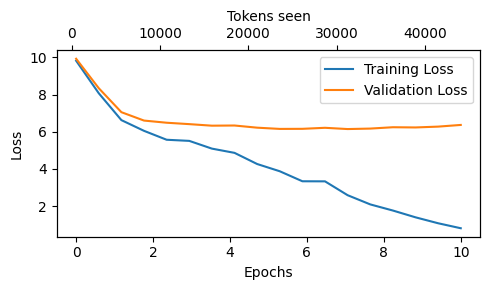

In [59]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5,3))

    #Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_losses, label="Training Loss")
    ax1.plot(epochs_seen, val_losses, label="Validation Loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True)) #Only show integer labels on x-axis

    #Create a second x-axis for tokens seen
    ax2 = ax1.twiny() #Create a second x-axis that shares the same y-axis
    ax2.plot(tokens_seen, train_losses, alpha=0) #Invisible plo for aligning ticks
    ax2.set_xlabel("Tokens seen")
    fig.tight_layout()
    plt.savefig("loss-plot.pdf")
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

In [60]:
#Decoding strategies to control randomness

In [61]:
model.to("cuda")

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

In [62]:
model.eval()

tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=25,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you?"

"Yes--quite insensible to the irony. She wanted him vindicated--and by me!"




In [63]:
#Temperature Scaling

In [64]:
vocab = {
    "closer": 0,
    "every": 1,
    "effort": 2,
    "forward": 3,
    "inches": 4,
    "moves": 5,
    "pizza": 6,
    "toward": 7,
    "you": 8,
}
inverse_vocab = {v:k for k, v in vocab.items()}
inverse_vocab

{0: 'closer',
 1: 'every',
 2: 'effort',
 3: 'forward',
 4: 'inches',
 5: 'moves',
 6: 'pizza',
 7: 'toward',
 8: 'you'}

In [65]:
next_token_logits = torch.tensor(
    [4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)

probas = torch.softmax(next_token_logits, dim=0)
probas

tensor([6.0907e-02, 1.6313e-03, 1.0019e-04, 5.7212e-01, 3.4190e-03, 1.3257e-04,
        1.0120e-04, 3.5758e-01, 4.0122e-03])

In [66]:
next_token_id = torch.argmax(probas).item()
next_token_id

3

In [67]:
inverse_vocab[next_token_id]

'forward'

In [68]:
torch.manual_seed(123)
next_token_id = torch.multinomial(probas, num_samples=1).item()
print(inverse_vocab[next_token_id])

toward


In [69]:
next_token_id = torch.multinomial(probas, num_samples=1).item()
print(inverse_vocab[next_token_id])

forward


In [70]:
next_token_id = torch.multinomial(probas, num_samples=1).item()
print(inverse_vocab[next_token_id])

toward


In [71]:
def print_sampled_tokens(probas):
    torch.manual_seed(123)
    sample = [torch.multinomial(probas, num_samples=1).item() for i in range(1_000)]
    sampled_ids = torch.bincount(torch.tensor(sample))
    for i,freq in enumerate(sampled_ids):
            print(f"{freq} X {inverse_vocab[i]}")

print_sampled_tokens(probas)

71 X closer
2 X every
0 X effort
544 X forward
2 X inches
1 X moves
0 X pizza
376 X toward
4 X you


In [72]:
def softmax_with_temperature(logits, temperature):
    scaled_logits = logits / temperature
    return torch.softmax(scaled_logits, dim=0)

In [73]:
temperatures = [1, 0.1, 5]

#Calculate scaled probabilites
scaled_probas = [softmax_with_temperature(next_token_logits, T) for T in temperatures]

In [74]:
scaled_probas[0]

tensor([6.0907e-02, 1.6313e-03, 1.0019e-04, 5.7212e-01, 3.4190e-03, 1.3257e-04,
        1.0120e-04, 3.5758e-01, 4.0122e-03])

In [75]:
probas

tensor([6.0907e-02, 1.6313e-03, 1.0019e-04, 5.7212e-01, 3.4190e-03, 1.3257e-04,
        1.0120e-04, 3.5758e-01, 4.0122e-03])

In [76]:
scaled_probas[1]

tensor([1.8530e-10, 3.5189e-26, 2.6890e-38, 9.9099e-01, 5.7569e-23, 4.4220e-37,
        2.9718e-38, 9.0133e-03, 2.8514e-22])

In [77]:
scaled_probas[2]

tensor([0.1546, 0.0750, 0.0429, 0.2421, 0.0869, 0.0454, 0.0430, 0.2203, 0.0898])

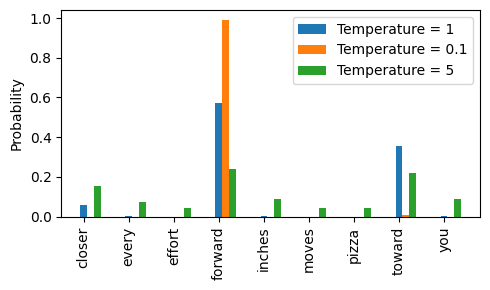

In [78]:
#Plotting
x = torch.arange(len(vocab))
bar_width = 0.15
fig, ax = plt.subplots(figsize=(5,3))
for i, T in enumerate(temperatures):
    rects = ax.bar( x + i * bar_width, scaled_probas[i], bar_width, label=f'Temperature = {T}')
ax.set_ylabel("Probability")
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(), rotation=90)
ax.legend()
plt.tight_layout()
plt.savefig("temperature-plot.pdf")
plt.show()

In [79]:
#Top-K sampling

In [80]:
next_token_logits = torch.tensor(
    [4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)

In [81]:
top_k = 3
top_logits, top_pos = torch.topk(next_token_logits, top_k)
print(top_logits, top_pos)

tensor([6.7500, 6.2800, 4.5100]) tensor([3, 7, 0])


In [82]:
new_logits = torch.where(
    condition = next_token_logits < top_logits[-1],
    input = torch.tensor(float("-inf")),
    other = next_token_logits
)

In [83]:
new_logits

tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])

In [84]:
torch.softmax(new_logits, dim=0)

tensor([0.0615, 0.0000, 0.0000, 0.5775, 0.0000, 0.0000, 0.0000, 0.3610, 0.0000])

In [85]:
#Modifying the text generation function

In [86]:
tokenizer.decode([50256])

'<|endoftext|>'

In [87]:
def generate(model, idx, max_new_tokens, context_size, temperature=1.0, top_k=None, eos_id=None):
    
    # Get the device the model's parameters are on
    device = next(model.parameters()).device
    # Ensure the initial input is on the same device as the model
    idx = idx.to(device)

    for _ in range(max_new_tokens):
        # Crop idx to the last context_size tokens
        idx_cond = idx[:, -context_size:]

        # Get the predictions from the model
        with torch.no_grad():
            logits = model(idx_cond)
        
        # Focus only on the logits for the last time step
        logits = logits[:, -1, :]

        # Apply top-k filtering if specified
        if top_k is not None:
            top_logits, _ = torch.topk(logits, top_k)
            # Set all logits not in the top-k to negative infinity
            logits[logits < top_logits[:, [-1]]] = float('-inf')

        # Apply temperature scaling and sample the next token
        if temperature > 0.0:
            # Apply temperature scaling
            scaled_logits = logits / temperature
            probs = torch.softmax(scaled_logits, dim=-1)
            
            # Sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)
        else:
            # Greedily select the most likely token (if temperature is 0)
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)
        
        # Stop if the end-of-sequence token is generated
        if eos_id is not None and idx_next == eos_id:
            break
            
        # Append the sampled token to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)

    return idx

In [90]:
gpt = GPTModel(GPT_CONFIG_124M)

device = "cuda" if torch.cuda.is_available() else "cpu"
gpt.to(device)

# The tokenizer is used on the CPU
tokenizer = tiktoken.get_encoding("gpt2")

# Generate text
torch.manual_seed(123) # for reproducibility
token_ids = generate(
    model=gpt,
    # Move the input tensor to the same device as the model
    idx=text_to_token_ids("Every effort moves you", tokenizer).to(device),
    max_new_tokens=15,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=25,
    temperature=1.4
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you causing Sed Pall household.] pops320 Jacksonvillegger £ discouraged synergy StarcraftCrossallic


In [91]:
token_ids = generate(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=15,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=25,
    #temperature=1.4
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you?"

I felt to Mrs. . . .

Well--


In [92]:
token_ids = generate(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=15,
    context_size=GPT_CONFIG_124M["context_length"],
    #top_k=25,
    temperature=1.4
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves youaldi benchmark phrase as chest of tea Seas nominations couldfcskirts renters then Sears


In [93]:
token_ids = generate(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=15,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=25,
    temperature=1.4
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you like to through my bravrowed by a smile that lifted the frame last


In [94]:
#Loading and saving model weights with PyTorch

In [95]:
torch.save(model.state_dict(), "model.pth")

In [96]:
from previous_chapters import GPTModel

GPT_CONFIG_124M = {
    "vocab_size": 50257, #Vocabulary size
    "context_length": 256, #Context length
    "emb_dim": 768, #Embedding Dimension
    "n_heads": 12, #Number of attention heads
    "n_layers": 12, #Number of layers
    "drop_rate": 0.1, #Dropout rate
    "qkv_bias": False #Query-Key-Value bias
}

model = GPTModel(GPT_CONFIG_124M)

In [97]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load("model.pth", map_location=device))

C:\Users\tanis\AppData\Local\Temp\ipykernel_16876\761034928.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model.pth", map_location=de

<All keys matched successfully>

In [98]:
#Loading pretrained weights from OpenAI

In [99]:
print("Tensorflow version:", version("tensorflow"))
print("tqdm version:", version("tqdm"))

Tensorflow version: 2.16.1
tqdm version: 4.66.4


In [100]:
from gpt_download import download_and_load_gpt2

In [101]:
settings, params = download_and_load_gpt2(model_size="124M", models_dir="gpt2")

Primary URL (https://openaipublic.blob.core.windows.net/gpt-2/models\124M\checkpoint) failed. Attempting backup URL: https://f001.backblazeb2.com/file/LLMs-from-scratch/gpt2\124M\checkpoint
Failed to download from both primary URL (https://openaipublic.blob.core.windows.net/gpt-2/models\124M\checkpoint) and backup URL (https://f001.backblazeb2.com/file/LLMs-from-scratch/gpt2\124M\checkpoint).
Check your internet connection or the file availability.
For help, visit: https://github.com/rasbt/LLMs-from-scratch/discussions/273
Primary URL (https://openaipublic.blob.core.windows.net/gpt-2/models\124M\encoder.json) failed. Attempting backup URL: https://f001.backblazeb2.com/file/LLMs-from-scratch/gpt2\124M\encoder.json
Failed to download from both primary URL (https://openaipublic.blob.core.windows.net/gpt-2/models\124M\encoder.json) and backup URL (https://f001.backblazeb2.com/file/LLMs-from-scratch/gpt2\124M\encoder.json).
Check your internet connection or the file availability.
For help, 

In [102]:
print("Settings:", settings)

Settings: {'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 768, 'n_head': 12, 'n_layer': 12}


In [103]:
print("Parameter dictionary keys:", params.keys())

Parameter dictionary keys: dict_keys(['blocks', 'b', 'g', 'wpe', 'wte'])


In [104]:
#Define model configurations in a dictionary for compactness

GPT_CONFIG_124M = {
    "vocab_size": 50257, #Vocabulary size
    "context_length": 1024, #Context length
    "emb_dim": 768, #Embedding Dimension
    "n_heads": 12, #Number of attention heads
    "n_layers": 12, #Number of layers
    "drop_rate": 0.1, #Dropout rate
    "qkv_bias": False #Query-Key-Value bias
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-x1 (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

#Copy the base configuration and update with specific model settings
model_name = "gpt2-small (124M)" #Example model name
NEW_CONFIG = GPT_CONFIG_124M.copy()
NEW_CONFIG.update(model_configs[model_name])
NEW_CONFIG.update({"context_length": 1024, "qkv_bias": True})

In [105]:
gpt = GPTModel(NEW_CONFIG)
gpt.eval();

In [106]:
def assign(left,right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, Right: {right.shape}")
    return torch.nn.Parameter(torch.tensor(right))

In [107]:
device = "cuda"

In [108]:
import numpy as np

def load_weights_into_gpt(gpt, params):
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params['wpe'])
    gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params['wte'])

    for b in range(len(params["blocks"])):
        q_w, k_w, v_w = np.split(
            (params["blocks"][b]["attn"]["c_attn"]) ["w"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.weight = assign(
            gpt.trf_blocks[b].att.W_query.weight, q_w.T)
        gpt.trf_blocks[b].att.W_key.weight = assign(
            gpt.trf_blocks[b].att.W_key.weight, k_w.T)
        gpt.trf_blocks[b].att.W_value.weight = assign(
            gpt.trf_blocks[b].att.W_value.weight, v_w.T)
        
        q_b, k_b, v_b = np.split(
            (params["blocks"][b]["attn"]["c_attn"]) ["b"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.bias = assign(
            gpt.trf_blocks[b].att.W_query.bias, q_b)
        gpt.trf_blocks[b].att.W_key.bias = assign(
            gpt.trf_blocks[b].att.W_key.bias, k_b)
        gpt.trf_blocks[b].att.W_value.bias = assign(
            gpt.trf_blocks[b].att.W_value.bias, v_b)
        
        gpt.trf_blocks[b].att.out_proj.weight = assign(
            gpt.trf_blocks[b].att.out_proj.weight,
            params["blocks"][b]["attn"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].att.out_proj.bias = assign(
            gpt.trf_blocks[b].att.out_proj.bias,
            params["blocks"][b]["attn"]["c_proj"]["b"])
        
        gpt.trf_blocks[b].ff.layers[0].weight = assign(
            gpt.trf_blocks[b].ff.layers[0].weight,
            params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        gpt.trf_blocks[b].ff.layers[0].bias = assign(
            gpt.trf_blocks[b].ff.layers[0].bias,
            params["blocks"][b]["mlp"]["c_fc"]["b"])
        gpt.trf_blocks[b].ff.layers[2].weight = assign(
            gpt.trf_blocks[b].ff.layers[2].weight,
            params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].ff.layers[2].bias = assign(
            gpt.trf_blocks[b].ff.layers[2].bias,
            params["blocks"][b]["mlp"]["c_proj"]["b"])
        
        gpt.trf_blocks[b].norm1.scale = assign(
            gpt.trf_blocks[b].norm1.scale,
            params["blocks"][b]["ln_1"]["g"])
        gpt.trf_blocks[b].norm1.shift = assign(
            gpt.trf_blocks[b].norm1.shift,
            params["blocks"][b]["ln_1"]["b"])
        gpt.trf_blocks[b].norm2.scale = assign(
            gpt.trf_blocks[b].norm2.scale,
            params["blocks"][b]["ln_2"]["g"])
        gpt.trf_blocks[b].norm2.shift = assign(
            gpt.trf_blocks[b].norm2.shift,
            params["blocks"][b]["ln_2"]["b"])
        
    gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
    gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
    gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])

load_weights_into_gpt(gpt, params)
gpt.to(device)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=7

In [109]:
token_ids = generate(
    model=gpt,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=15,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=25,
    temperature=1.4
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you through every step with an inexorabilible force. It has no effect
